In [1]:
import numpy as np

import matplotlib.pyplot as plt
from torch import nn
import torch as th

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(20, 5),
            nn.ReLU(),
            nn.Linear(5, 20),
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

In [ ]:
def proj_eq(h0: float, u: float, t: np.array):
    g = 9.8
    return h0 + u * t - 0.5 * g * t**2


def derivative(y, x):
    """
    Computes dy/dx using PyTorch's autograd.
    y and x must be tensors with requires_grad=True for x.
    """
    return th.autograd.grad(y, x, grad_outputs=th.ones_like(y), create_graph=True)[0]


def initial_condition_loss(model):
    """
    Enforce h(0) = h0.
    """
    # Evaluate at t=0
    t0 = th.zeros(20, dtype=th.float32, requires_grad=False)
    h0_pred = model(t0)
    return (h0_pred - h0).pow(2).mean()


h0 = 3
u = 3
g = 9.8
t = np.linspace(0, 5, 20)
y = proj_eq(h0=h0, u=u, t=t)
y_hat = y + 5 * np.random.randn(len(y))

dydt = u - g * t
y_hat

array([   1.45966375,   -2.84786877,   11.94700277,    0.88437353,
         -8.07452013,   -2.33086504,    2.90942262,  -14.56148856,
        -13.40093086,  -16.89953486,  -34.10347276,  -35.25194733,
        -36.48433435,  -35.84859832,  -49.58620122,  -61.30117502,
        -62.27419227,  -87.97453242,  -95.64200541, -107.2059316 ])

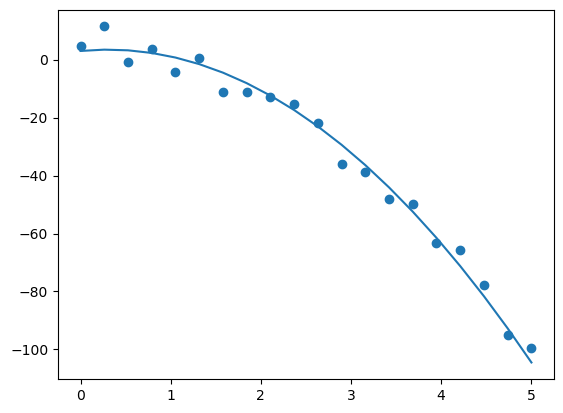

In [17]:
plt.plot(t, y)
plt.scatter(t, y_hat)

In [ ]:
nn_pinn = NeuralNetwork()

th_t = th.tensor(t, dtype=th.float32, requires_grad=True)
th_y = th.tensor(y, dtype=th.float32)
th_y_hat = th.tensor(y_hat, dtype=th.float32)
th_dydt = th.tensor(dydt, dtype=th.float32)
dydt = th.tensor(dydt, dtype=th.float32)

learning_rate = 0.01
opt = th.optim.Adam(nn_pinn.parameters(), lr=learning_rate)
ctr = th.nn.MSELoss()
for u in range(2000):
    y_pred = nn_pinn.forward(th_t)

    dydt_pred = derivative(nn_pinn(th_t), th_t)
    pde_loss = th.mean((dydt_pred - dydt) ** 2)
    bound_loss = initial_condition_loss(nn_pinn)
    loss = ctr(y_pred, th_y_hat) + pde_loss + bound_loss

    # loss = (y_pred - y_hat).pow(2).sum()
    if u % 100 == 99:
        print(u, loss.item())

    # Use autograd to compute the backward pass.
    opt.zero_grad()
    loss.backward()

    opt.step()

99 234.16921997070312
199 199.40103149414062
299 182.53656005859375
399 167.68194580078125
499 151.8966827392578
599 132.1873779296875
699 103.20529174804688
799 63.68611526489258
899 27.773452758789062
999 8.803028106689453
1099 84.49958801269531
1199 38.90406799316406
1299 12.441387176513672
1399 3.5616047382354736
1499 1.3032392263412476
1599 0.6082070469856262
1699 0.30475249886512756
1799 0.15359780192375183
1899 0.0773494765162468
1999 0.03918497636914253


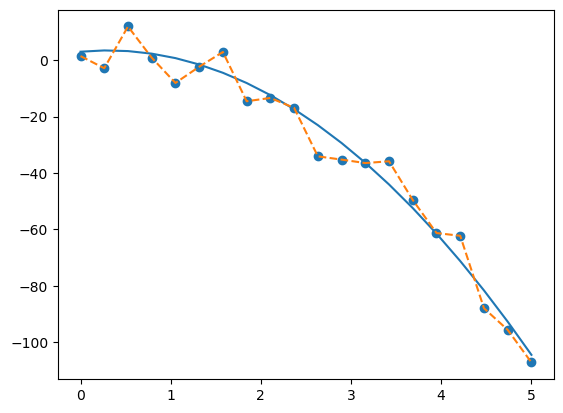

In [ ]:
plt.plot(t, y)
plt.scatter(t, y_hat)
plt.plot(t, nn_pinn(th_t).detach().numpy(), ls="--")
# plt.plot(t.detach().numpy(), y_div.detach(), ls="--")